In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fcAntenna = 150e6
fs = 8000
t = np.arange(0,1,1/fs)
Lambda = 3e8 / fcAntenna
nAntenna = 10
nSample = 1024 # sample rate for calc Rx
SNR = -50
degree = np.arange(-90, 90)

In [3]:
def SteeringVec(angels):
    # It is assumed that the distance of each antenna element is Lambda / 2
    steeringVec = np.zeros(nAntenna, dtype='complex_')
    k0 = 2 * np.pi / Lambda
    if np.size(angels) != 2:
        angels = [angels , 0]
    for i in range(nAntenna):
        d = i * Lambda / 2
        steeringVec[i] = np.exp(-1j * k0 * d * np.sin(angels[0]) * np.cos(angels[1]))
    return steeringVec

In [4]:
def CollectPlaneWave(angels, *args, **kwargs):
    planeWave = np.zeros((fs, nAntenna), dtype='complex_')

    steeringVec = np.zeros((nAntenna, len(args)), dtype='complex_')
    for i in range(len(args)):
        steeringVec[:, i] = SteeringVec(angels[i])

    noise = np.sqrt(1 / (10 ** (SNR / 10))) * np.random.randn(fs)
    
    amplitudeVec = np.zeros((len(args), fs))
    for i in range(len(args)):
        amplitudeVec[i, :] = args[i] + noise

    planeWave = (steeringVec @ amplitudeVec).T

    return planeWave

In [5]:
sig1 = np.cos(2 * np.pi * 300 * t)
sig2 = np.cos(2 * np.pi * 400 * t)
sig3 = np.cos(2 * np.pi * 600 * t)
signalAngels = [[-50, 0], [20, 0], [80, 0]]
sig = CollectPlaneWave(signalAngels, sig1, sig2, sig3)

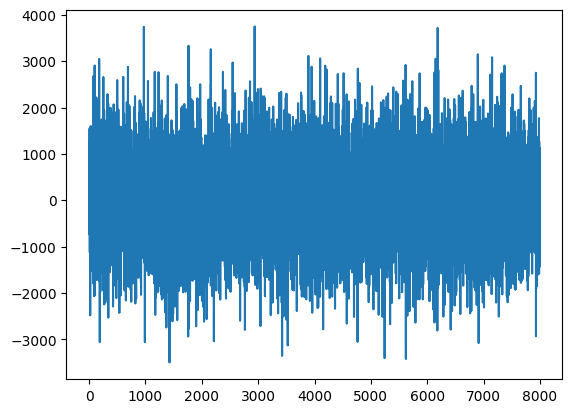

In [6]:
plt.plot(np.real(sig)[:,0])

In [7]:
np.shape(sig)

(8000, 10)

In [8]:
def CAPON(data, nSample, fs, angels):
    # R = np.zeros((nAntenna, nAntenna), dtype='complex_')
    R = (data[0:nSample, :].T @ data[0:nSample, :].conj()) / nSample

    steeringVec = SteeringVec(angels)

    steeringVecTranspose = np.matrix(steeringVec).getH()

    Pcapon = steeringVecTranspose.T @ np.linalg.inv(R) @ steeringVec.T
    out_vec = 1 / Pcapon.real

    return out_vec

C:\Users\asakh\AppData\Local\Temp\ipykernel_11572\56918074.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = np.abs(CAPON(sig, nSample, fs, degree[i]))


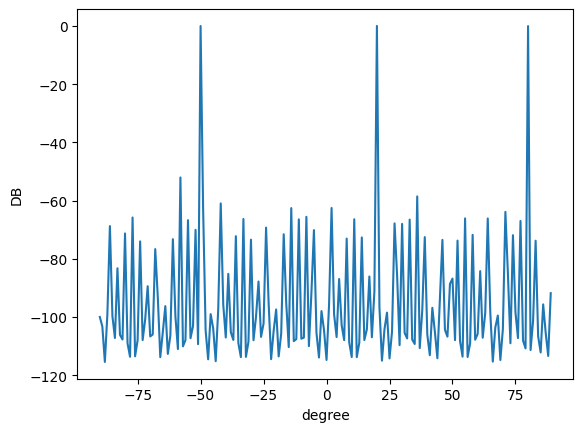

In [9]:
result = np.zeros(len(degree))
for i in range(0, 180):
    result[i] = np.abs(CAPON(sig, nSample, fs, degree[i]))
result = 10 * np.log10(result / np.max(result))
plt.plot(degree, result)
plt.xlabel('degree')
plt.ylabel('DB')
plt.show()